In [20]:
from scripts.ising_simulation import IsingSimulation
import numpy as np
from joblib import Parallel, delayed
from matplotlib import pyplot as plt

In [77]:

def calc_susceptibility(beta, J, n_rois, eq_steps=300, mc_steps=200):
    sim = IsingSimulation(n_rois, beta, coupling_mat = True, J=J)
    energy_eq = []
    mag_eq = []
    for i in range(eq_steps):
        sim.step()
        energy_eq.append(sim.calcEnergy())
        mag_eq.append(sim.calcMag())
    mag = []
    mag_squared = []
    energy = []
    energy_squared = []
    for i in range(mc_steps):
        sim.step()
        mag.append(sim.calcMag())
        energy.append(sim.calcEnergy())
        mag_squared.append(mag[-1]**2)
        energy_squared.append(energy[-1]**2)
    chi = (np.mean(mag_squared) - np.mean(mag)**2) / (beta * n_rois * n_rois) 
    # return chi, mag, energy, energy_eq, mag_eq
    return chi

In [62]:
ising_reps = np.load('../data/AAL_reps/ising_NYU.npy')
fc_rep_ut = np.load('../data/AAL_reps/sfc_NYU.npy')
diag = np.load('../data/AAL_reps/diag_NYU.npy')
betas = np.load('../data/AAL_reps/betas_NYU.npy')
n_rois = ising_reps.shape[1]
fc_reps = np.zeros((fc_rep_ut.shape[0], n_rois, n_rois))
for i in range(fc_rep_ut.shape[0]):
    fc_reps[i][np.triu_indices(n_rois)] = fc_rep_ut[i]
    fc_reps[i] = np.triu(fc_reps[i]) + np.tril(fc_reps[i].T, k=-1)

In [15]:
fc_reps.shape, ising_reps.shape

((170, 116, 116), (170, 116, 116))

In [63]:
betas

array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.04, 0.03, 0.03, 0.03, 0.04,
       0.03, 0.03, 0.03, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.04, 0.03, 0.03, 0.03, 0.04, 0.03, 0.04, 0.03, 0.04, 0.04,
       0.04, 0.03, 0.03, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.03, 0.04, 0.03, 0.04, 0.03, 0.03, 0.03,
       0.04, 0.03, 0.04, 0.03, 0.03, 0.03, 0.04, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.04, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.04, 0.03, 0.03, 0.04, 0.03, 0.03, 0.01,
       0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.04, 0.03,
       0.04, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.

In [16]:
fc_pos = fc_reps[diag == 1]
fc_neg = fc_reps[diag == 0]
ising_pos = ising_reps[diag == 1]
ising_neg = ising_reps[diag == 0]

In [17]:
ising_pos.shape, fc_pos.shape

((97, 116, 116), (97, 116, 116))

In [82]:
beta_range = np.arange(0.2, 3.05, 0.05)
beta_range = np.arange(0.01, 0.1, 0.005)
chi_pos = []
for beta in beta_range:
    chi_pos.append(Parallel(n_jobs=6)(delayed(calc_susceptibility)(beta, J, n_rois) for J in ising_pos))

In [83]:
chi_neg = []
for beta in beta_range:
    chi_neg.append(Parallel(n_jobs=6)(delayed(calc_susceptibility)(beta, J, n_rois) for J in ising_neg))

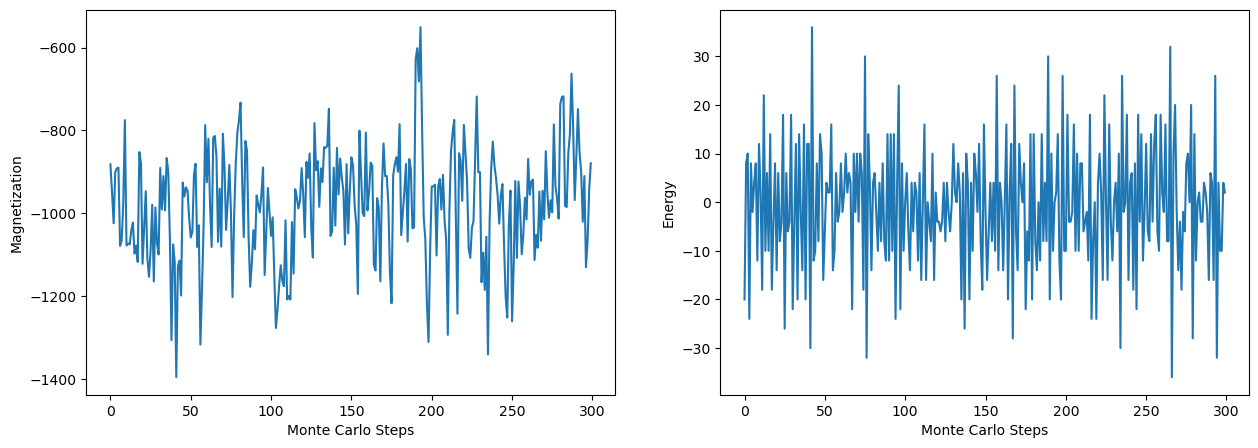

In [41]:
# plot magnetization and energy with proper labels
def plot_mag_energy(mag, energy):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(mag)
    plt.xlabel('Monte Carlo Steps')
    plt.ylabel('Magnetization')
    plt.subplot(1, 2, 2)
    plt.plot(energy)
    plt.xlabel('Monte Carlo Steps')
    plt.ylabel('Energy')
    plt.show()
    return
plot_mag_energy(mag_eq, energy_eq)

In [46]:
chi_pos = np.array(chi_pos)
chi_neg = np.array(chi_neg)

/tmp/ipykernel_650/968328201.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  chi_pos = np.array(chi_pos)


In [51]:
chi_pos_bak = chi_pos

In [52]:
chi_pos = chi_pos[:, :, 0]

In [53]:
chi_pos_mean = np.mean(chi_pos, axis=1)
chi_neg_mean = np.mean(chi_neg, axis=1)

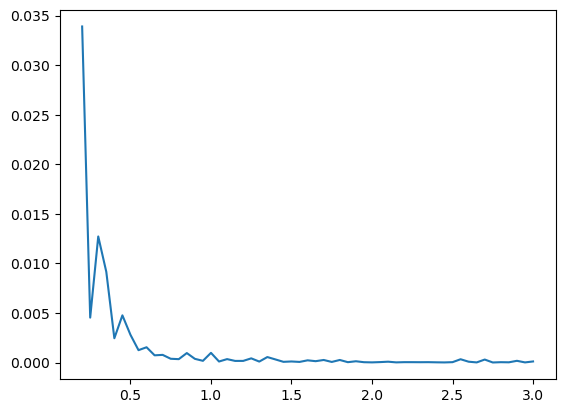

In [54]:
plt.plot(beta_range, chi_pos_mean)

In [55]:
chi_pos_mean

array([0.033902847156674014, 0.004531964279147307, 0.012716951724546547,
       0.009151614644533896, 0.002450534081297455, 0.004761820120867407,
       0.0027992306348603065, 0.0012488081533676512,
       0.0015416434268645984, 0.0007288934663899409,
       0.0007731371018441804, 0.0003806962542546723,
       0.00034224413744070065, 0.0009557215521387598,
       0.00037398655734936244, 0.0001726275078824472,
       0.0009768928435711043, 0.0001037836294894094,
       0.0003456093350732815, 0.0001635604611487379,
       0.00016520485757832613, 0.00042266318937935756,
       9.712649964498257e-05, 0.0005532420744045996,
       0.00031398085332175077, 7.149538853285685e-05,
       0.00010780295508129401, 6.300187592406801e-05,
       0.00022306537266937815, 0.00013751801142701327,
       0.00025852014408617375, 6.094793875724582e-05,
       0.0002585135141577219, 3.6686115488963655e-05,
       0.0001294985348037331, 3.428155654733006e-05,
       1.6795558184290236e-05, 4.4652373920552763

In [81]:
chi_single = []
print(len(beta_range))
for beta in beta_range:
    chi_single.append(calc_susceptibility(beta, ising_pos[0], n_rois))

18


KeyboardInterrupt: 

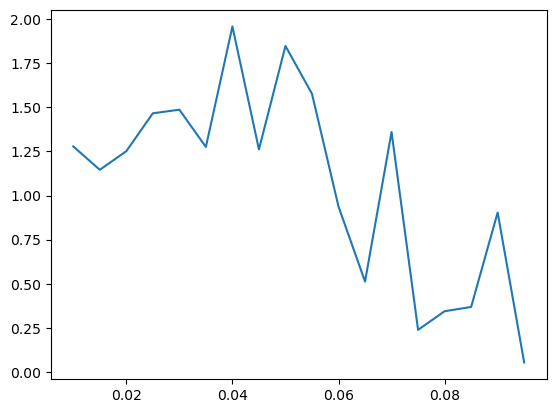

In [79]:
plt.plot(beta_range, chi_single)

In [68]:
k = np.load('../data/mica-mics/betas_main.npy')

In [69]:
k

array([0.01, 0.1 , 0.01, 0.01, 0.1 , 0.01, 0.01, 0.01, 0.01, 0.1 , 0.01,
       0.1 , 0.1 , 0.1 , 0.1 , 0.01, 0.1 , 0.1 , 0.01, 0.01, 0.1 , 0.1 ,
       0.1 , 0.1 , 0.01, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ,
       0.01, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.01, 0.1 , 0.1 , 0.1 ,
       0.01, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ])